In [1]:
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt


# Football Prediction results using Betting Odds

The project's goal is to predict the results of the Football game using Betting information before the beginning of the match. We will also be exploring and building new features which can be constructed before the start of the game. 

Let us begin by Exploring the Dataset and its column names

In [2]:
df = pd.read_csv('E0.csv')
print(f"Shape of dataset {df.shape}")
df.head()


Shape of dataset (366, 106)


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,13/08/2021,20:00,Brentford,Arsenal,2,0,H,1,0,...,1.62,0.50,1.75,2.05,1.81,2.13,2.05,2.17,1.80,2.09
1,E0,14/08/2021,12:30,Man United,Leeds,5,1,H,1,0,...,2.25,-1.00,2.05,1.75,2.17,1.77,2.19,1.93,2.10,1.79
2,E0,14/08/2021,15:00,Burnley,Brighton,1,2,A,1,0,...,1.62,0.25,1.79,2.15,1.81,2.14,1.82,2.19,1.79,2.12
3,E0,14/08/2021,15:00,Chelsea,Crystal Palace,3,0,H,2,0,...,1.94,-1.50,2.05,1.75,2.12,1.81,2.16,1.93,2.06,1.82
4,E0,14/08/2021,15:00,Everton,Southampton,3,1,H,0,1,...,1.67,-0.50,2.05,1.88,2.05,1.88,2.08,1.90,2.03,1.86


According to the problem statement, the description of the Column Names is given in this file [here](https://football-data.co.uk/notes.txt). I have copy-pasted the values here. Let us try understanding which key values are present and not.

In [3]:
text = open("key_description.txt", "r").read()

text = text.split('\n')
print(f"Number of available column descriptions from text file {len(text)}")
print("--------------------------------------------------------- \n")

print(f"Following are the availble keys in our current datasets with description available\n")
text_p = [t.split()  for t in text]
keys_df = df.keys().tolist()
counts = 0
documented_keys = []
description_dict = {}
for i, t in enumerate(text_p):
    if t[0] in keys_df:
        print(text[i])
        counts += 1
        documented_keys.append(t[0])
        description_dict[t[0]] = text[i]

print(f"\nTotal Count of availble keys {counts}")
print("--------------------------------------------------------- \n")

print(f"Following are list of keys which do not have a description but are available in the dataframe \n")
unrecorded_keys = list(set(keys_df) - set(documented_keys))
print(', '.join(unrecorded_keys))


Number of available column descriptions from text file 122
--------------------------------------------------------- 

Following are the availble keys in our current datasets with description available

Div = League Division
Date = Match Date (dd/mm/yy)
Time = Time of match kick off
HomeTeam = Home Team
AwayTeam = Away Team
FTHG and HG = Full Time Home Team Goals
FTAG and AG = Full Time Away Team Goals
FTR and Res = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)
Referee = Match Referee
HS = Home Team Shots
AS = Away Team Shots
HST = Home Team Shots on Target
AST = Away Team Shots on Target
HC = Home Team Corners
AC = Away Team Corners
HF = Home Team Fouls Committed
AF = Away Team Fouls Committed
HY = Home Team Yellow Cards
AY = Away Team Yellow Cards
HR = Home Team Red Cards
AR = Away Team Red Cards
B365H = Bet365 home win odds
B365D = Bet365 draw odds
B365A = Be

---

# Conclusion from the text file

- There are 108 column names in the data frame and 128 key descriptions available in the text file. Out of these keys with explanation, only 65 are present.

- There are 43 column names in our dataset whose descriptions we do not have. According to the document - " Closing Odds are represented by additional "C" character following the bookmaker abbreviation/Max/Avg". 
- Below are the list of all the betting houses with their corresponding codes.

```
betting_houses = {
    'Bet365': ['B365H', 'B365D', 'B365A'],
    'Bet&Win': ['BWH', 'BWD', 'BWA'],
    'Interwetten': ['IWH', 'IWD', 'IWA'],
    'Pinnacle': ['PSH', 'PSD', 'PSA'],
    'VC Bet': ['VCH', 'VCD', 'VCA'],
    'William Hill': ['WHH', 'WHD', 'WHA'],
    'Average': ['AvgH', 'AvgD', 'AvgA'],
    'Maximum': ['MaxH', 'MaxD', 'MaxA']
}

```
```
betting_houses_closing = {
    'Bet365': ['B365CH', 'B365CD', 'B365CA'],
    'Bet&Win': ['BWCH', 'BWCD', 'BWCA'],
    'Interwetten': ['IWCH', 'IWCD', 'IWCA'],
    'Pinnacle': ['PSCH', 'PSCD', 'PSCA'],
    'VC Bet': ['VCCH', 'VCCD', 'VCCA'],
    'William Hill': ['WHCH', 'WHCD', 'WHCA'],
    'Average': ['AvgCH', 'AvgCD', 'AvgCA'],
    'Maximum': ['MaxCH', 'MaxCD', 'MaxCA']
}
```
- Those 43 features represent the closing odds of various betting houses. 



---

# Features

We are given two types of - Match Performance statistics and Odds provided by different Betting Houses.

1. Match Features

    - General Information that dont determine the outcome of the game (Date, Referee)
    - Statistics of Events in the game - (No. of Red Cards, Corners, goals, etc.)

2. Betting Odds
    - Normal Betting
    - Asian Handicapped Bets
 
Let's understand the distribution of Each of these features, and let's also try building our features if possible.

The target variable is 'FTR', which indicates the outcome of the football match.

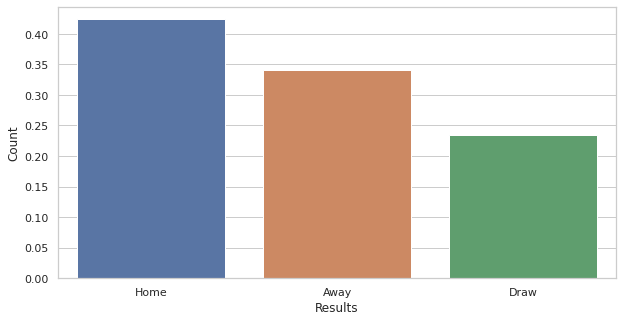

In [4]:
df['FTR'] = df['FTR'].replace({'A': 'Away', 'H': 'Home', 'D': 'Draw'})
result_counts = df['FTR'].value_counts(normalize=True).reset_index()

result_counts.columns = ["Results", "Count"]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Results", y="Count", data=result_counts)


## 1. Match Features

We are provided with match features that give us information about the match event.


In [5]:
# List of Match feature keys, split into categories
match_features = {
    "general": ['Div', 'Date', 'Time', 'Referee'],
    "match_stats": ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
}



Lets look at the Division information, All games are from EPL Div 0 league

In [6]:
df['Div'].value_counts()

E0    366
Name: Div, dtype: int64

---

Now lets take a look at the dates of the game.

In [7]:
# Lets try converting Date & Time keys to DateTime python objects

df['Datetime'] = df['Date'] + " " + df['Time']+":00"
df['Datetime'] = pd.to_datetime(df['Datetime'], infer_datetime_format=True)
df['match_no'] = range(1, len(df) + 1)
df['FTR'] = df['FTR'].replace({'A': 'Away', 'H': 'Home', 'D': 'Draw'})


In [8]:
# df[['Datetime']].describe()

In this Dataset we are provided with games conducted between `11 Jan 2021` to `05 Dec 2022`

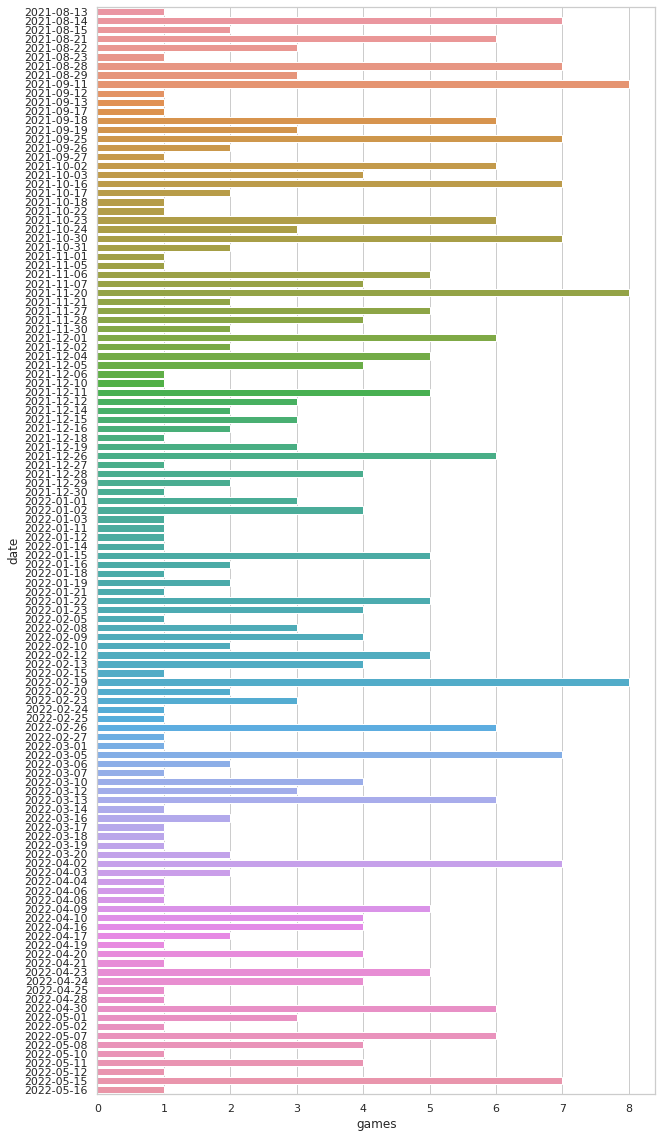

In [9]:
date_counts = df['Datetime'].dt.date.value_counts().reset_index().sort_values(by="index")
date_counts.columns = ["date", "games"]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,20))
ax = sns.barplot(x="games", y="date", data=date_counts)


Lets also analyse on what days of the week, the games are played

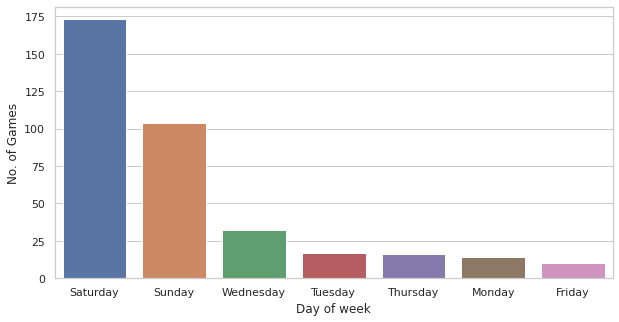

In [10]:
day_counts = df['Datetime'].dt.day_name().value_counts().reset_index()

day_counts.columns = ["Day of week", "No. of Games"]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Day of week", y="No. of Games", data=day_counts)



Now let us look at the distribution of the outcome of games with the Days on which matches were played. Expected results, effect of distribution must be independent of the days on which games are played, i.e. Home teams should have a higher advantage

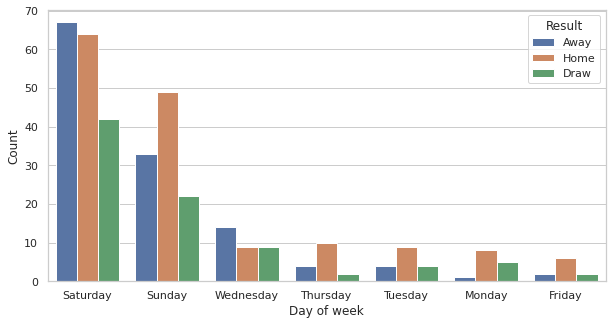

In [11]:
df['Day of week'] = df['Datetime'].dt.day_name()
day_counts_comp = df[['Day of week', 'FTR']].value_counts().reset_index()
day_counts_comp.columns = ["Day of week", "Result", "Count"]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Day of week", y="Count", hue="Result", data=day_counts_comp)



The results of the above graph look a bit surprising. We have the maximum number of games played on Saturday, and "Away" teams seem to have a higher chance of winning. Let's understand better if it is related to Top Tier Teams given games on Weekends instead of Weekdays. 

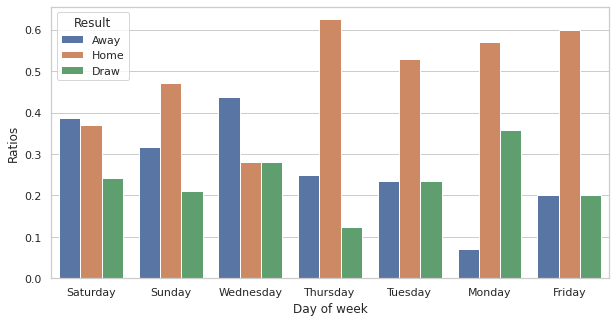

In [12]:
day_counts_comp = pd.merge(day_counts_comp, day_counts, on="Day of week")
day_counts_comp["Ratios"] = day_counts_comp["Count"]/day_counts_comp["No. of Games"]
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.barplot(x="Day of week", y="Ratios", hue="Result", data=day_counts_comp)


Here is a side by side plot, number of games each Refree has handled and the results of the game. Is it possible that some refrees are biased to Home or Away side?

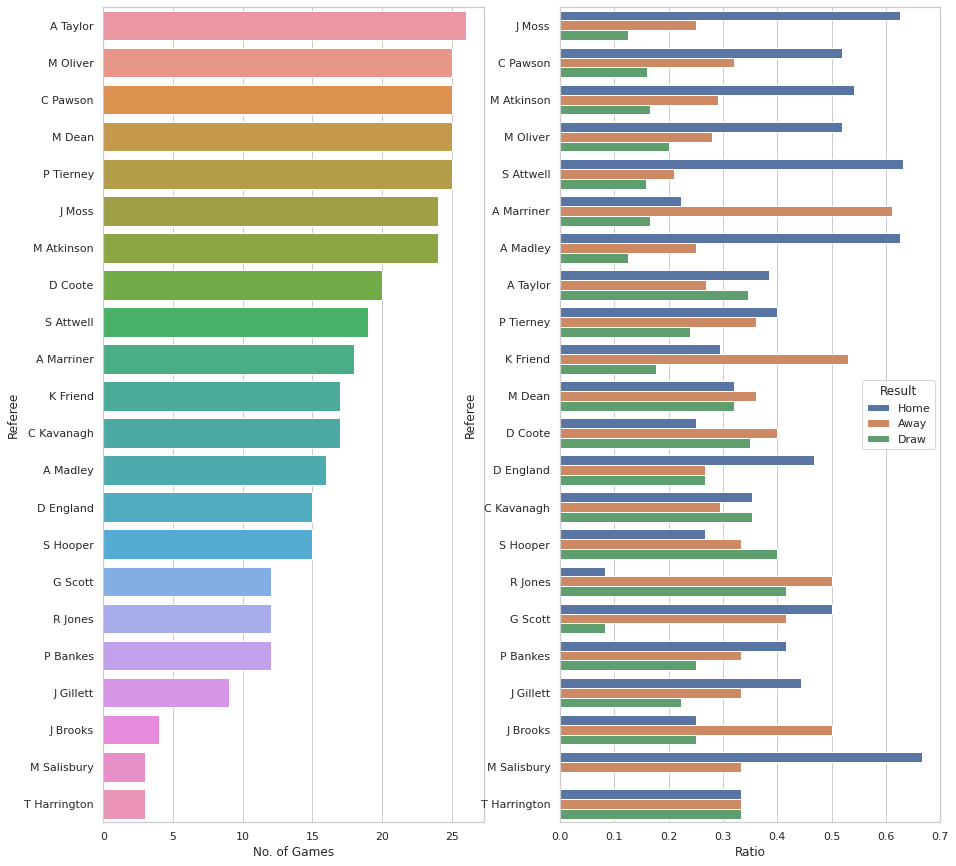

In [13]:
f, axes = plt.subplots(1, 2, figsize=(15,15))

refree_counts = df['Referee'].value_counts().reset_index()
refree_counts.columns = ["Referee", "No. of Games"]
sns.set_theme(style="whitegrid")
sns.barplot(x="No. of Games", y="Referee", data=refree_counts, ax=axes[0])

refree_comp = df[['Referee', 'FTR']].value_counts().reset_index()
refree_comp.columns = ["Referee", "Result", "Count"]

refree_comp = pd.merge(refree_comp, refree_counts, on="Referee")
refree_comp["Ratio"] = refree_comp["Count"]/refree_comp["No. of Games"]
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Ratio", y="Referee", hue="Result", data=refree_comp, ax=axes[1])



Now let us look at all the teams playing in the league and their win records.
Here is the list of teams playing - 

Brentford, Man United, Burnley, Chelsea, Everton, Leicester, Watford, Norwich, Newcastle, Tottenham, Liverpool, Aston Villa, Crystal Palace, Leeds, Man City, Brighton, Southampton, Wolves, Arsenal, West Ham

Here we will try computing the average stats per game, as few teams have played more games than others. (17 to 19 games for each)

In [14]:
Teams = df['HomeTeam'].unique().tolist()
stat_keys = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'Points Home']
points_dict = {"Home": 3, "Away": 0, "Draw": 1}
df['Points Home'] = df['FTR'].apply(lambda x: points_dict[x])
points_dict = {"Home": 0, "Away": 3, "Draw": 1}
df['Points Away'] = df['FTR'].apply(lambda x: points_dict[x])
home_team_results = df.groupby('HomeTeam')[stat_keys].mean().reset_index().sort_values(by="HomeTeam")
home_team_results.columns = ["Home Team", "Average Goals scored as Home", "Average Goals conceded at Home", "Average Shots taken at Home", "Average Shots conceded at Home", "Target Shots taken at Home", "Average Target Shots conceded at Home", "Average Points Gained at Home"]

stat_keys = ['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'Points Away']
away_team_results = df.groupby('AwayTeam')[stat_keys].mean().reset_index().sort_values(by="AwayTeam")
away_team_results.columns = ["Away Team", "Average Goals conceded at Away", "Average Goals scored as Away", "Average Shots conceded at Away", "Average Shots taken at Away", "Average Target Shots conceded at Away", "Target Shots taken at Away", "Average Points Gained at Away"]


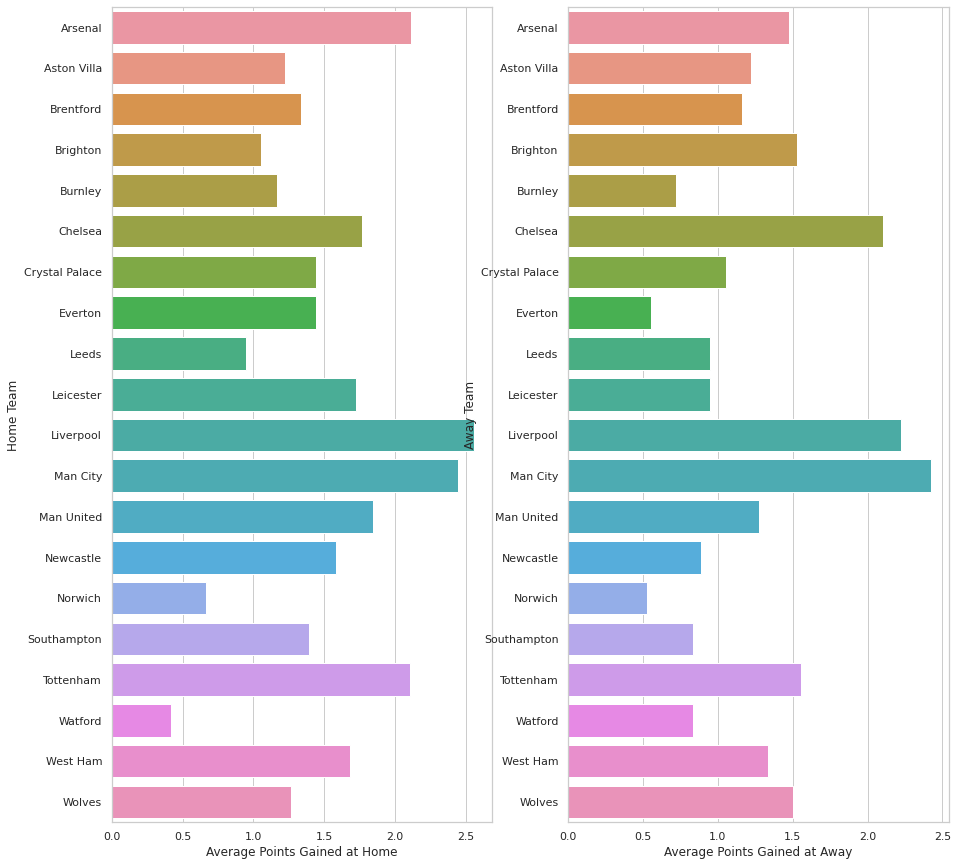

In [15]:
f, axes = plt.subplots(1, 2, figsize=(15,15))
ax = sns.barplot(x="Average Points Gained at Home", y="Home Team", data=home_team_results, ax=axes[0])
ax = sns.barplot(x="Average Points Gained at Away", y="Away Team", data=away_team_results, ax=axes[1])


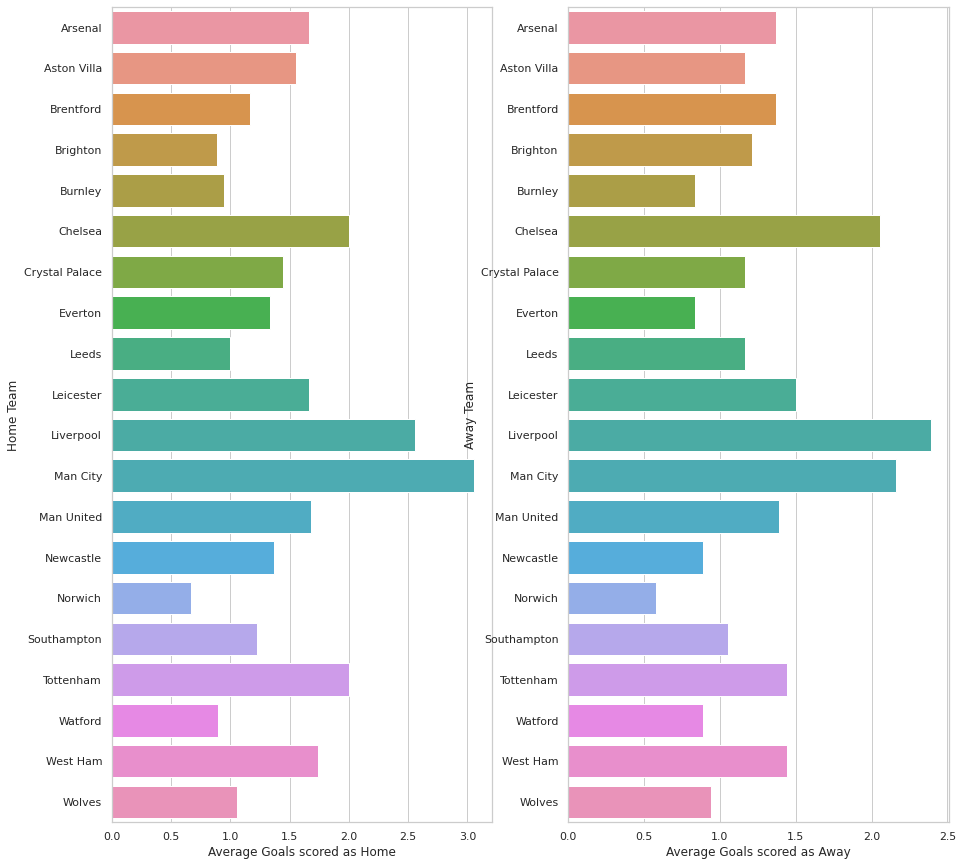

In [16]:
f, axes = plt.subplots(1, 2, figsize=(15,15))
ax = sns.barplot(x="Average Goals scored as Home", y="Home Team", data=home_team_results, ax=axes[0])
ax = sns.barplot(x="Average Goals scored as Away", y="Away Team", data=away_team_results, ax=axes[1])



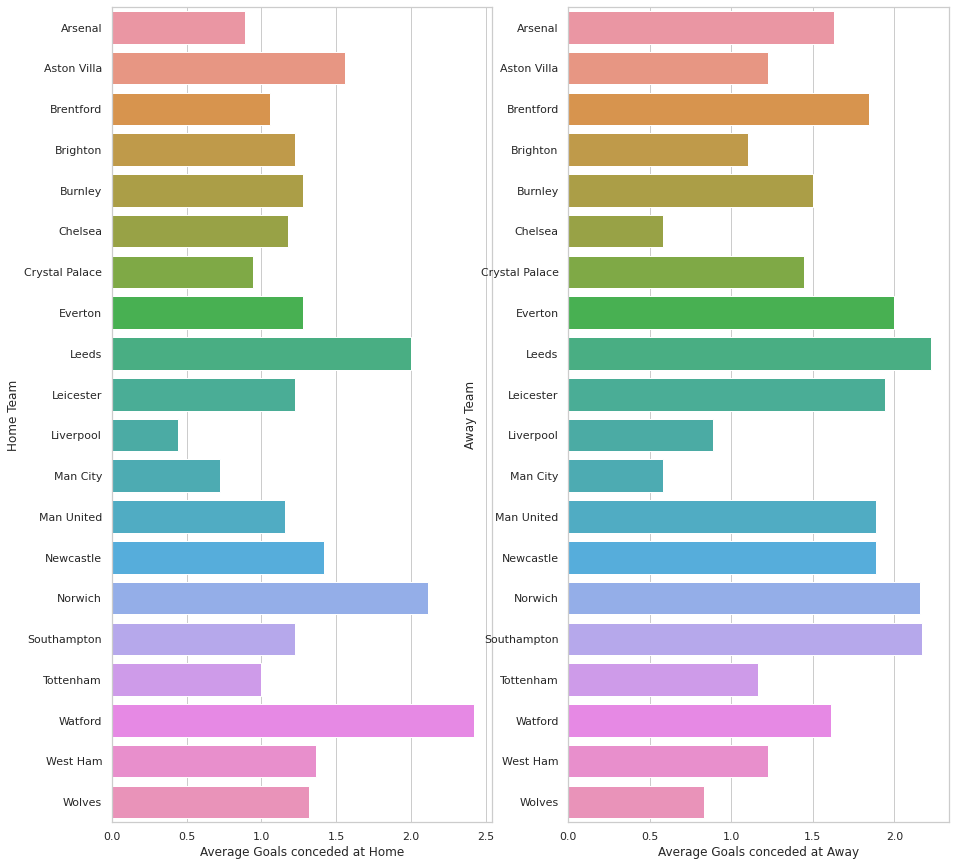

In [17]:
f, axes = plt.subplots(1, 2, figsize=(15,15))
ax = sns.barplot(x="Average Goals conceded at Home", y="Home Team", data=home_team_results, ax=axes[0])
ax = sns.barplot(x="Average Goals conceded at Away", y="Away Team", data=away_team_results, ax=axes[1])
